In [31]:
#import os
#jdbcPathUbuntu = '/usr/share/java/postgresql-42.2.23.jar'
#jdbcPathMacOS = '/Users/cristianomartinsm/postgresql-42.2.23.jar'
#jdbcPath = jdbcPathUbuntu
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-class-path ' + jdbcPath + ' --jars ' + jdbcPath + ' pyspark-shell'
#import databricks.koalas as ks
import matplotlib.pyplot as plt
from matplotlib.dates import num2date
import matplotlib.lines as mlines
import psycopg2 as pg
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime, timedelta
import copy
from heapq import heapify, heappop, heappush, heappushpop

In [32]:
kmLimit = 3000
subFolder = 'Restricted 1 31 Partial Floating/'

textParams =    {'Free Floating/':  {'number': 0.7,
                                     'text': '07',
                                     'maxParking': float('inf')},
                 'Mixed Free Floating/': {'number': 0.9,
                                             'text': '09',
                                             'maxParking': float('inf')},
                 'Restricted 1 31 Partial Floating/':   {'number': 0.9,
                                                         'text': '09',
                                                         'maxParking': 31},
                 'Restricted 1 62 Partial Floating/':   {'number': 0.7,
                                                         'text': '07',
                                                         'maxParking': 62},
                 'Restricted 1 inf Partial Floating/':  {'number': 0.7,
                                                         'text': '07',
                                                         'maxParking': float('inf')}
                }

numberMultiplier = textParams[subFolder]['number']
textMultiplier = textParams[subFolder]['text']
maxParkingSlots = textParams[subFolder]['maxParking']
highMultiplier = 0.7
extraMultiplier = 0.91
specialCasesFileName = {highMultiplier: {'filename': 'Optimal Solutions/Free Floating/4000/500/70.json',
                                         'maxParking': textParams['Free Floating/']['maxParking']
                                        },
                        extraMultiplier: {'filename': 'Optimal Solutions/Mixed Free Floating/3000/500/90.json',
                                          'maxParking': textParams['Mixed Free Floating/']['maxParking']
                                        }
                        }

folderData = 'Optimal Solutions/' + subFolder + str(kmLimit) + '/'
folderSave = Path('./IEEE T-ITS/' + subFolder + str(kmLimit))
folderSave.mkdir(parents=True, exist_ok=True)

In [33]:
#SERVED CLIENTS GRAPH
params = {'host':'localhost', 'port':'5432', 'database':'afterqualifying', 'user':'cristiano', 'password':'cristiano'}
def loadMaxAmountTrips():
    conn = pg.connect(**params)
    cur = conn.cursor()

    sqlQuery = '''	select	sum(floor(TRIP.TRIPEXPANSIONFACTOR))
                    from	TRIP;
                    '''
    cur.execute(sqlQuery)
    maxAmountTrips = cur.fetchone()[0]
    cur.close()
    conn.close()

    return maxAmountTrips

def loadTrips():
    conn = pg.connect(**params)

    sqlQuery = '''	select	TRIP.IDTRIP,
                            TRIP.TRIPEXPANSIONFACTOR,
                            TRIP.MAINMODE,
                            TRIP.DRIVINGDISTANCE,
                            TRIP.DRIVINGDURATION,
                            TRIP.TIMESTAMPDEPARTURE,
                            TRIP.TIMESTAMPARRIVAL,
                            TRIP.REASONDEPARTURE,
                            TRIP.REASONDESTINATION
                    from	TRIP
                    where   TRIP.DRIVINGDISTANCE > 500
                    '''
    dataFrameEdges = pd.read_sql_query(sqlQuery, conn)
    conn.close()

    trips = dict()
    for row in dataFrameEdges.itertuples():
        dictRow = row._asdict()
        trip = Trip(idTrip=dictRow['idtrip'],
                    expansionFactor=dictRow['tripexpansionfactor'],
                    mainMode=dictRow['mainmode'],
                    drivenDistance=dictRow['drivingdistance'],
                    drivenDuration=dictRow['drivingduration'],
                    timestampDeparture=dictRow['timestampdeparture'],
                    timestampArrival=dictRow['timestamparrival'],
                    departureReason=dictRow['reasondeparture'],
                    destinationReason=dictRow['reasondestination'])
        trips[trip.idTrip] = trip

    return trips

class Trip:
    #Values for defining the new timestamps
    ADJUSTED_MONTH = 1
    ADJUSTED_YEAR = 2017

    amountPeopleMainMode = {}
    amountServedMainMode = {numberMultiplier:   {},
                            highMultiplier:     {},
                            extraMultiplier:    {}
    }
    
    amountPeopleDepartureReason = {}
    amountServedDepartureReason = { numberMultiplier:   {},
                                    highMultiplier:     {},
                                    extraMultiplier:    {}
    }
    amountPeopleDestinationReason = {}
    amountServedDestinationReason = {   numberMultiplier:   {},
                                        highMultiplier:     {},
                                        extraMultiplier:    {}
    }

    drivenDistances = { 'all':  [],
                        numberMultiplier:   [],
                        highMultiplier:     [],
                        extraMultiplier:    []
    }

    def adjustDay(timeDepartureOld, drivingDuration):
        #The weekday() starts from 0 but it does not exist a day 0 in the calendar. Then, a +1 solves this issue
        adjustedDayDeparture = timeDepartureOld.weekday() + 1

        timeDepartureNew = timeDepartureOld.replace(day=adjustedDayDeparture, month=Trip.ADJUSTED_MONTH, year=Trip.ADJUSTED_YEAR)
        timeArrivalNew = timeDepartureNew + timedelta(minutes=drivingDuration)
        
        return timeDepartureNew, timeArrivalNew
    
    def incrementPeople(key, increment, dictToCheck, dictServed):
        if key not in dictToCheck:
            dictToCheck[key] = increment
            dictServed[numberMultiplier][key] = 0
            dictServed[highMultiplier][key] = 0
            dictServed[extraMultiplier][key] = 0
        else:
            dictToCheck[key] += increment
        
    def __init__(self, idTrip, expansionFactor, mainMode, drivenDistance, drivenDuration, timestampDeparture, timestampArrival, departureReason, destinationReason):
        self.idTrip = idTrip
        self.expansionFactor = expansionFactor
        self.mainMode = mainMode
        self.drivenDistance = drivenDistance
        self.drivenDuration = drivenDuration
        self.timestampDepartureOld = timestampDeparture
        self.timestampArrivalOld = timestampArrival
        self.departureReason = departureReason
        self.destinationReason = destinationReason

        self.timestampDeparture, self.timestampArrival = Trip.adjustDay(timestampDeparture, self.drivenDuration)

        Trip.incrementPeople(self.mainMode, self.expansionFactor, Trip.amountPeopleMainMode, Trip.amountServedMainMode)
        Trip.incrementPeople(self.departureReason, self.expansionFactor, Trip.amountPeopleDepartureReason, Trip.amountServedDepartureReason)
        Trip.incrementPeople(self.destinationReason, self.expansionFactor, Trip.amountPeopleDestinationReason, Trip.amountServedDestinationReason)

        Trip.drivenDistances['all'].append(self.drivenDistance/1000)

maxAmountTrips = loadMaxAmountTrips()
allocatedStations = {}
amountServedTrips = {}
totalDrivenDistance = {}
stationsStart = {   numberMultiplier:   dict(),
                    highMultiplier:     dict(),
                    extraMultiplier:    dict()
}
stationsBalance = { numberMultiplier:   list(),
                    highMultiplier:     list(),
                    extraMultiplier:    list()
}
INITIAL_TIMESTAMP = datetime(year=Trip.ADJUSTED_YEAR, month=Trip.ADJUSTED_MONTH, day=1, hour=0, minute=0, second=0)
trips = loadTrips()
dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        percentagePrice = int(round(pricesMultiplier*100, 0))
        multiplierStable = round(pricesMultiplier, 1)

        #Workaround using multiplierStable to include analysis of MixedFreeFloating
        if multiplierStable == 0.6:
            percentagePrice = int(round(extraMultiplier*100, 0))
            multiplierStable = round(extraMultiplier, 2)
            fileName = specialCasesFileName[extraMultiplier]['filename']
        elif multiplierStable == 0.7:
            fileName = specialCasesFileName[multiplierStable]['filename']
        else:
            fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'

        keyTotalTrips = str(distanceCutOff) + '_' + str(percentagePrice)
        allocatedStations[keyTotalTrips] = 0
        amountServedTrips[keyTotalTrips] = 0
        totalDrivenDistance[keyTotalTrips] = 0

        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                for var in optimalSolution["Vars"]:
                    varVTag = var["VTag"][0]
                    varVTagSplit = varVTag.split('_')

                    if varVTag.startswith('station') and varVTag.endswith('start'):
                        amountVehicles = int(var["X"])
                        if amountVehicles > 0:
                            allocatedStations[keyTotalTrips] += amountVehicles

                            if distanceCutOff == 500 and multiplierStable in [numberMultiplier, highMultiplier, extraMultiplier]:
                                idStation = int(varVTagSplit[1])
                                stationsStart[multiplierStable][idStation] = amountVehicles
                                #stationsBalance[multiplierStable].append((idStation, INITIAL_TIMESTAMP, amountVehicles))

                    elif varVTag.startswith('trip'):
                        idTrip = int(varVTagSplit[1])
                        if varVTag.endswith('filter'):
                            amountServed = int(var["X"])
                            if amountServed > 0:
                                amountServedTrips[keyTotalTrips] += amountServed
                                totalDrivenDistance[keyTotalTrips] += amountServed * trips[idTrip].drivenDistance/1000
                            
                                if distanceCutOff == 500 and multiplierStable in [numberMultiplier, highMultiplier, extraMultiplier]:
                                    tripMainMode = trips[idTrip].mainMode
                                    tripDepartureReason = trips[idTrip].departureReason
                                    tripDestinationReason = trips[idTrip].departureReason
                                    Trip.amountServedMainMode[multiplierStable][tripMainMode] += amountServed
                                    Trip.amountServedDepartureReason[multiplierStable][tripDepartureReason] += amountServed
                                    Trip.amountServedDestinationReason[multiplierStable][tripDestinationReason] += amountServed

                                    Trip.drivenDistances[multiplierStable].append(trips[idTrip].drivenDistance/1000)

                        elif distanceCutOff == 500 and multiplierStable in [numberMultiplier, highMultiplier, extraMultiplier] and varVTagSplit[2] in ['start', 'end']:
                            idStation = int(varVTagSplit[4])
                            vehiclesFlow = int(var["X"])
                            if varVTagSplit[2] == 'start':
                                stationsBalance[multiplierStable].append((idStation, trips[idTrip].timestampDeparture, -1*vehiclesFlow))
                            else:
                                stationsBalance[multiplierStable].append((idStation, trips[idTrip].timestampArrival, vehiclesFlow))

                dataList.append((   pricesMultiplier,
                                    distanceCutOff,
                                    100*amountServedTrips[keyTotalTrips]/maxAmountTrips,
                                    allocatedStations[keyTotalTrips],
                                    4*totalDrivenDistance[keyTotalTrips]/allocatedStations[keyTotalTrips]))
        except FileNotFoundError:
            break
        
folderData = 'Optimal Solutions/' + subFolder + str(kmLimit) + '/'

def loadStations():
    conn = pg.connect(**params)

    sqlQuery = '''	select  STATION.IDSTATION,
                            EDGE.PARKINGEXPENSES
                    from    STATION, STREETSEGMENT as EDGE
                    where   EDGE.IDEDGE = STATION.IDEDGE_FK '''
    dataFrameEdges = pd.read_sql_query(sqlQuery, conn)
    conn.close()

    stations = dict()
    for row in dataFrameEdges.itertuples():
        dictRow = row._asdict()
        station = Station(  idStation=dictRow['idstation'],
                            parkingExpenses=dictRow['parkingexpenses'])
        stations[station.idStation] = station

    return stations

class Station:
    def __init__(self, idStation, parkingExpenses):
        self.idStation = idStation
        self.parkingExpenses = parkingExpenses
        

####### PRICE MULTIPLIER 0.7 #######
            station  calcbalance      balance
count   6773.000000   6773.00000  6773.000000
mean   27659.735420     12.00812    12.460210
std    26218.269036     18.44737    17.978282
min        1.000000    -73.00000     0.000000
25%     3757.000000      0.00000     0.000000
50%    11226.000000      1.00000     2.000000
75%    55363.000000     21.00000    21.000000
max    71547.000000    154.00000   154.000000
         calcbalance  station  balance                  timestamp
weekday                                                          
0                -60     4981        0 2017-01-01 00:00:00.000000
1                -73     1276        0 2017-01-02 07:10:00.000000
2                -39      922        0 2017-01-03 12:01:07.299313
3                -39      922        0 2017-01-04 13:30:00.000000
4                -11    45130        0 2017-01-05 20:15:00.000000
5                -73     1276        0 2017-01-06 17:20:00.000000
6                -73 

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.7 #######
            station  calcbalance      balance
count   6773.000000  6773.000000  6773.000000
mean   27659.735420    11.519120    11.653772
std    26218.269036    17.853562    18.179988
min        1.000000   -73.000000   -73.000000
25%     3757.000000     0.000000     0.000000
50%    11226.000000     1.000000     1.000000
75%    55363.000000    21.000000    21.000000
max    71547.000000    88.000000    88.000000
         calcbalance  station  balance           timestamp
weekday                                                   
0                -60     4981      -60 2017-01-01 00:00:00
1                -73     1276      -73 2017-01-02 07:10:00
2                -50      748      -50 2017-01-03 06:40:00
3                -39      922      -39 2017-01-04 13:30:00
4                -30     2978      -30 2017-01-05 18:20:00
5                -73     1276      -73 2017-01-06 17:20:00
6                -73     1276      -73 2017-01-07 08:30:00
0                 

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.7 #######
            station  calcbalance      balance
count   6773.000000  6773.000000  6773.000000
mean   27659.735420    11.050347    11.306806
std    26218.269036    17.695210    18.141648
min        1.000000   -81.000000   -81.000000
25%     3757.000000     0.000000     0.000000
50%    11226.000000     1.000000     1.000000
75%    55363.000000    21.000000    21.000000
max    71547.000000    74.000000    74.000000
         calcbalance  station  balance           timestamp
weekday                                                   
0                -60     4981      -60 2017-01-01 00:00:00
1                -81    56483      -81 2017-01-02 15:00:00
2                -63      748      -63 2017-01-03 06:40:00
3                -39      922      -39 2017-01-04 13:30:00
4                -44     2978      -44 2017-01-05 18:20:00
5                -73     1276      -73 2017-01-06 17:20:00
6                -73     1276      -73 2017-01-07 08:30:00
0                 

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.7 #######
            station  calcbalance      balance
count   6773.000000  6773.000000  6773.000000
mean   27659.735420    10.552931    10.929130
std    26218.269036    17.649205    18.173086
min        1.000000   -89.000000   -89.000000
25%     3757.000000     0.000000     0.000000
50%    11226.000000     0.000000     1.000000
75%    55363.000000    21.000000    21.000000
max    71547.000000    66.000000    66.000000
         calcbalance  station  balance           timestamp
weekday                                                   
0                -63     5545      -63 2017-01-01 12:50:00
1                -89    56483      -89 2017-01-02 15:00:00
2                -71      748      -71 2017-01-03 06:40:00
3                -39      922      -39 2017-01-04 13:30:00
4                -52     2978      -52 2017-01-05 18:20:00
5                -73     1276      -73 2017-01-06 17:20:00
6                -73     1276      -73 2017-01-07 08:30:00
0                 

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.91 #######
            station   calcbalance       balance
count  25039.000000  25039.000000  25039.000000
mean   26593.153001     19.863573     21.727944
std    25387.597612     37.397956     36.085642
min        1.000000   -263.000000      0.000000
25%     4061.500000      0.000000      0.000000
50%    12363.000000      3.000000      5.000000
75%    53932.000000     30.000000     33.000000
max    71573.000000    380.000000    380.000000
         calcbalance  station  balance                  timestamp
weekday                                                          
0               -194    57628       69 2017-01-01 07:00:00.000000
1               -173    62993        0 2017-01-02 19:00:00.000000
2               -173    62993        0 2017-01-03 17:10:00.000000
3               -121      922        0 2017-01-04 13:30:00.000000
4               -108     3587        0 2017-01-05 19:45:00.000000
5               -263    57628        0 2017-01-06 09:05:00.000000
6 

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.91 #######
            station   calcbalance       balance
count  25039.000000  25039.000000  25039.000000
mean   26593.153001     16.917209     17.624066
std    25387.597612     35.232093     36.820162
min        1.000000   -263.000000   -263.000000
25%     4061.500000      0.000000      0.000000
50%    12363.000000      1.000000      1.000000
75%    53932.000000     29.000000     30.000000
max    71573.000000    174.000000    174.000000
         calcbalance  station  balance                  timestamp
weekday                                                          
0               -194    57628     -194 2017-01-01 07:00:00.000000
1               -207     7367     -207 2017-01-02 21:53:44.551312
2               -207     7367     -207 2017-01-03 12:25:00.000000
3               -207     7367     -207 2017-01-04 11:30:00.000000
4               -173     3121     -173 2017-01-05 13:40:00.000000
5               -263    57628     -263 2017-01-06 09:05:00.000000
6 

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.91 #######
            station   calcbalance       balance
count  25039.000000  25039.000000  25039.000000
mean   26593.153001     14.151923     15.397220
std    25387.597612     35.499801     37.544428
min        1.000000   -263.000000   -263.000000
25%     4061.500000      0.000000      0.000000
50%    12363.000000      0.000000      1.000000
75%    53932.000000     28.000000     29.000000
max    71573.000000    133.000000    135.000000
         calcbalance  station  balance                  timestamp
weekday                                                          
0               -218    38598     -218 2017-01-01 18:30:00.000000
1               -246     7367     -246 2017-01-02 21:53:44.551312
2               -246     6455     -246 2017-01-03 06:55:00.000000
3               -246     7367     -246 2017-01-04 11:30:00.000000
4               -213     3121     -213 2017-01-05 13:40:00.000000
5               -263    57628     -263 2017-01-06 09:05:00.000000
6 

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.91 #######
            station   calcbalance       balance
count  25039.000000  25039.000000  25039.000000
mean   26593.153001     11.245018     13.000719
std    25387.597612     36.094230     38.427007
min        1.000000   -268.000000   -268.000000
25%     4061.500000      0.000000      0.000000
50%    12363.000000      0.000000      0.000000
75%    53932.000000     26.000000     28.000000
max    71573.000000    113.000000    113.000000
         calcbalance  station  balance                  timestamp
weekday                                                          
0               -240    38598     -240 2017-01-01 18:30:00.000000
1               -268     7367     -268 2017-01-02 21:53:44.551312
2               -268     7367     -268 2017-01-03 12:25:00.000000
3               -268     7367     -268 2017-01-04 11:30:00.000000
4               -234     3121     -234 2017-01-05 13:40:00.000000
5               -263    57628     -263 2017-01-06 09:05:00.000000
6 

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.9 #######
            station   calcbalance       balance
count  20014.000000  20014.000000  20014.000000
mean   26493.178675     12.249725     13.891426
std    25965.001353     25.477146     25.291316
min        1.000000    -31.000000      0.000000
25%     3643.000000     -1.000000      0.000000
50%    10031.000000      0.000000      1.000000
75%    54708.000000     18.000000     20.000000
max    71547.000000    346.000000    347.000000
         calcbalance  station  balance                  timestamp
weekday                                                          
0                -31     1072        0 2017-01-01 20:20:00.000000
1                -31     1276        0 2017-01-02 07:10:00.000000
2                -31      920        0 2017-01-03 12:01:44.800971
3                -31      922        0 2017-01-04 13:30:00.000000
4                -31     1072        0 2017-01-05 17:45:00.000000
5                -31     1996        0 2017-01-06 23:00:00.000000
6  

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.9 #######
            station   calcbalance       balance
count  20014.000000  20014.000000  20014.000000
mean   26493.178675      8.585990      9.687868
std    25965.001353     23.423466     25.175559
min        1.000000    -31.000000    -31.000000
25%     3643.000000     -1.000000     -1.000000
50%    10031.000000      0.000000      0.000000
75%    54708.000000     14.000000     16.000000
max    71547.000000    285.000000    316.000000
         calcbalance  station  balance                  timestamp
weekday                                                          
0                -31     1072      -31 2017-01-01 20:20:00.000000
1                -31      122      -31 2017-01-02 11:35:00.000000
2                -31      421      -31 2017-01-03 14:20:39.056982
3                -31      134      -31 2017-01-04 19:00:00.000000
4                -31      122      -31 2017-01-05 08:40:00.000000
5                -31      122      -31 2017-01-06 06:45:00.000000
6  

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.9 #######
            station   calcbalance       balance
count  20014.000000  20014.000000  20014.000000
mean   26493.178675      5.479364      7.107025
std    25965.001353     22.704393     25.309825
min        1.000000    -31.000000    -31.000000
25%     3643.000000     -1.000000     -1.000000
50%    10031.000000     -1.000000     -1.000000
75%    54708.000000     11.000000     14.000000
max    71547.000000    285.000000    316.000000
         calcbalance  station  balance                  timestamp
weekday                                                          
0                -31      863      -31 2017-01-01 10:00:00.000000
1                -31      122      -31 2017-01-02 11:35:00.000000
2                -31      421      -31 2017-01-03 14:20:39.056982
3                -31      134      -31 2017-01-04 19:00:00.000000
4                -31      122      -31 2017-01-05 08:40:00.000000
5                -31      122      -31 2017-01-06 06:45:00.000000
6  

/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


####### PRICE MULTIPLIER 0.9 #######
            station   calcbalance       balance
count  20014.000000  20014.000000  20014.000000
mean   26493.178675      2.625212      4.649246
std    25965.001353     22.371655     25.583207
min        1.000000    -31.000000    -31.000000
25%     3643.000000     -2.000000     -2.000000
50%    10031.000000     -1.000000     -1.000000
75%    54708.000000      8.000000     12.000000
max    71547.000000    285.000000    316.000000
         calcbalance  station  balance           timestamp
weekday                                                   
0                -31      253      -31 2017-01-01 14:15:00
1                -31       22      -31 2017-01-02 07:55:00
2                -31       22      -31 2017-01-03 15:35:00
3                -31       22      -31 2017-01-04 14:20:00
4                -31       22      -31 2017-01-05 16:40:00
5                -31       22      -31 2017-01-06 07:25:00
6                -31       22      -31 2017-01-07 14:35:00


/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)
/tmp/ipykernel_6389/2950122000.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


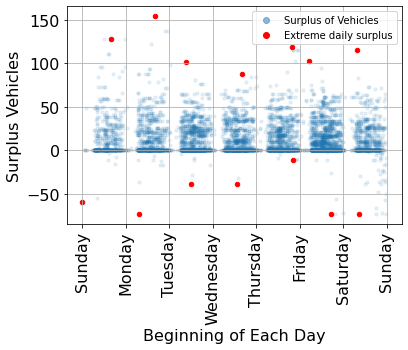

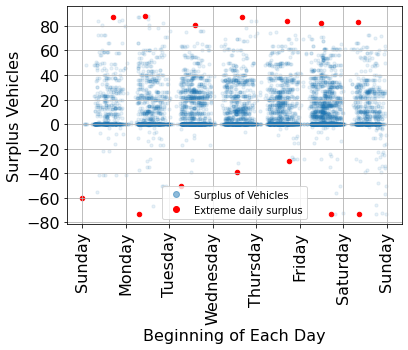

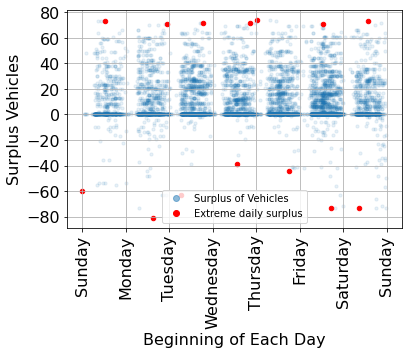

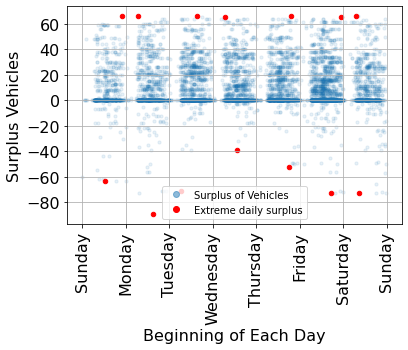

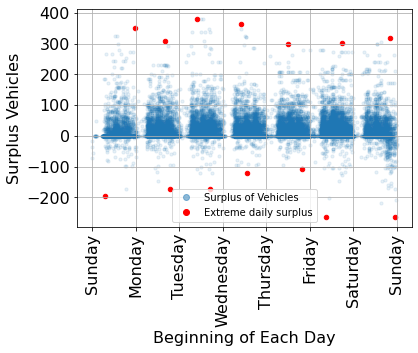

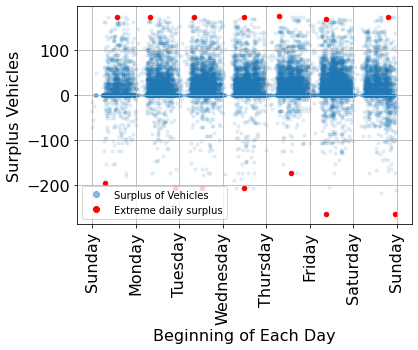

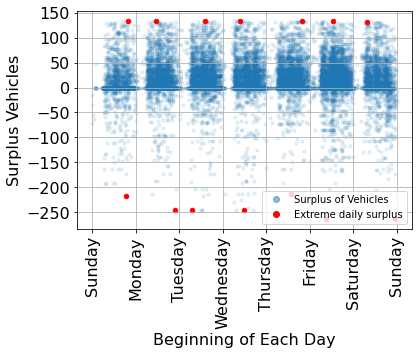

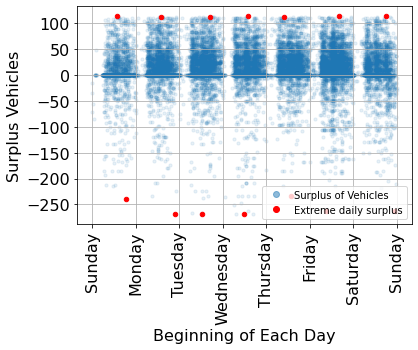

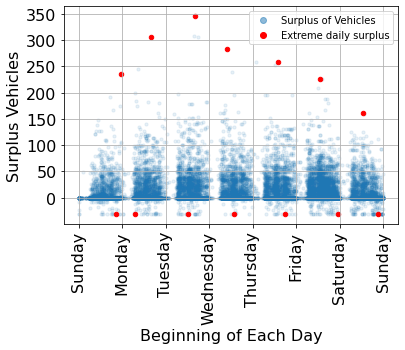

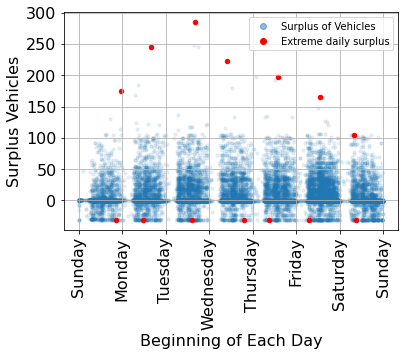

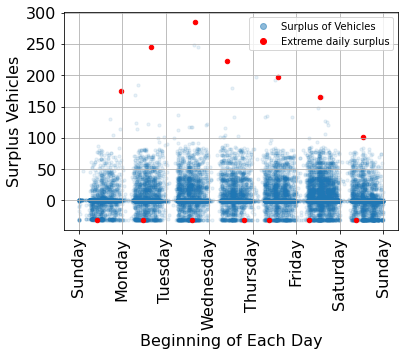

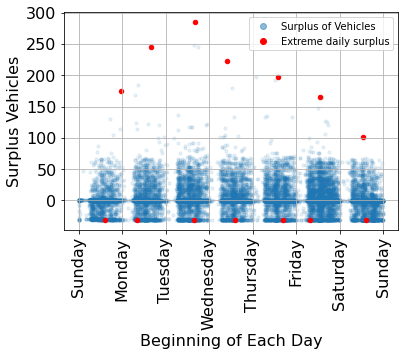

In [34]:
def prepareScatterPlot(dataFrame, xColumn, yColumn, xLabel, yLabel, fileName, legendTitle=None, legendLocation='best', pointSize=10, alpha=1, fontSize=16, color=None, rot=90, lastAx=None, lastAxColor=None, xTicks=None, yTicks=None, yLim=[None, None]):
    ax = dataFrame.plot.scatter(x=xColumn, y=yColumn, s=pointSize, alpha=alpha, fontsize=fontSize, c=color, rot=rot, grid=True, ax=lastAx)

    xTicksLoc, xTicksLabels = plt.xticks()
    newLabels = list()
    for xtick in xTicksLoc:
        newLabels.append(num2date(xtick).strftime("%A"))
    ax.set_xticklabels(newLabels)

    ax.set_xlabel(xLabel, fontsize=fontSize)
    ax.set_ylabel(yLabel, fontsize=fontSize)

    if lastAx is not None:
        bluePoint = mlines.Line2D([], [], color=lastAxColor, alpha=0.5, label='Surplus of Vehicles', marker='o', linestyle='None')
        redPoint = mlines.Line2D([], [], color='red', label='Extreme daily surplus', marker='o', linestyle='None')

        legendObject = ax.legend(handles=[bluePoint, redPoint], title=legendTitle, loc=legendLocation)

    ax.set_xlabel(xLabel, fontsize=16)
    ax.set_ylabel(yLabel, fontsize=16)

    ax.set_ylim(yLim)

    if xTicks is not None:
        ax.set_xticks(xTicks)
    if yTicks is not None:
        ax.set_yticks(yTicks)
    
    plt.savefig(fileName, format='pdf', bbox_inches="tight")
    #plt.show()

    return ax

def mergeExtremePoints(dataFrame, minOrMax):
    #Fixing pandas weekday to start at Sunday, as matplotlib and datetime uses
    dataFrame['weekday'] = dataFrame['timestamp'].dt.weekday
    dataFrame['weekday'] = np.where(dataFrame['weekday'] <= 5, dataFrame['weekday'] + 1, 0)

    if minOrMax == 'min':
        points = dataFrame.groupby(dataFrame['weekday'])[['calcbalance']].min()
    elif minOrMax == 'max':
        points = dataFrame.groupby(dataFrame['weekday'])[['calcbalance']].max()

    points.reset_index(inplace=True)
    points = pd.merge(points, dataFrame, on=['weekday', 'calcbalance'])
    points = points.groupby(points['weekday']).first()

    return points

def buildBalanceDataFrame(stationsBalance, pricesMultiplier):
    dataFramePd = pd.DataFrame(stationsBalance[pricesMultiplier], columns=['timestamp', 'station', 'calcbalance', 'balance'])
    dataFramePd = dataFramePd.set_index('timestamp')
    dataFramePd['timestamp'] = dataFramePd.index
    print('####### PRICE MULTIPLIER', pricesMultiplier, '#######')
    print(dataFramePd.describe())

    #Adjust the last points to the beginning of the first week
    mask = dataFramePd['timestamp'] >= INITIAL_TIMESTAMP + timedelta(weeks=1)
    dataFramePd.loc[mask, 'timestamp'] = dataFramePd.loc[mask, 'timestamp'].apply(lambda dateTooLate: dateTooLate - timedelta(weeks=1))

    minPoints = mergeExtremePoints(dataFrame=dataFramePd, minOrMax='min')
    maxPoints = mergeExtremePoints(dataFrame=dataFramePd, minOrMax='max')
    redPoints = pd.concat([minPoints, maxPoints])
    print(redPoints)

    return dataFramePd, redPoints

def reinvestInParkingSlots(dataFrame, budget, stations, stationsParking, maximumParkingSlots):
    highestCalcBalanceStations = dataFrame.groupby('station')[['calcbalance']].max()
    increasesParkingSlots = dict()
    heapStationsCalcBalances = list()
    for index, row in highestCalcBalanceStations.iterrows():
        #Heapq uses a min-heap implementation. The -1 is needed to simulate a max-heap
        heapStationsCalcBalances.append((-1*highestCalcBalanceStations.loc[index, 'calcbalance'], stations[index].parkingExpenses, index))
        increasesParkingSlots[index] = 0
    heapify(heapStationsCalcBalances)

    reachedMaximumParkingSlots = list()
    (highestBalance, cost, idStation) = heappop(heapStationsCalcBalances)
    while len(heapStationsCalcBalances) > 0 and budget > 0 and highestBalance < 0:
        #Checking whether the maximum number of parking slots was reached
        if stationsParking[idStation] + increasesParkingSlots[idStation] < maximumParkingSlots:
            budget -= cost
            increasesParkingSlots[idStation] += 1
            (highestBalance, cost, idStation) = heappushpop(heapStationsCalcBalances, (highestBalance + 1, stations[idStation].parkingExpenses, idStation))
        else:
            reachedMaximumParkingSlots.append((highestBalance, cost, idStation))
            (highestBalance, cost, idStation) = heappop(heapStationsCalcBalances)

    #Pushes back the last item got from the heap in the "for" above
    heappush(heapStationsCalcBalances, (highestBalance, cost, idStation))
    #Pushes back all items that reached the maximum number of parking slots
    heapStationsCalcBalances.extend(reachedMaximumParkingSlots)
    heapify(heapStationsCalcBalances)

    newStationsParking = dict()
    for (highestBalance, cost, idStation) in heapStationsCalcBalances:
        newStationsParking[idStation] = stationsParking[idStation] + increasesParkingSlots[idStation]

    return newStationsParking

def calcBalanceReinvested(budgetSimulations, stationsStart, stationsNParkingSlots):
    stationsAbsoluteBalance = copy.deepcopy(budgetSimulations)
    stationsAbsoluteBalance.sort()
    i = 0
    while i < len(stationsAbsoluteBalance):
        currentStation = stationsAbsoluteBalance[i][0]
        if currentStation not in stationsNParkingSlots:
            stationsNParkingSlots[currentStation] = 0

        earlierAbsoluteBalance = stationsStart[currentStation] - stationsNParkingSlots[currentStation]

        while i < len(stationsAbsoluteBalance) and currentStation == stationsAbsoluteBalance[i][0]:
            #Initially, idStation comes first in the tuple sequence to keep the sorting rationale
            (idStation, timestamp, vehiclesFlow) = stationsAbsoluteBalance[i]
            stationsAbsoluteBalance[i] = (timestamp, idStation, earlierAbsoluteBalance - stationsNParkingSlots[currentStation], earlierAbsoluteBalance)
            earlierAbsoluteBalance += vehiclesFlow

            i += 1
    #Repeating this line because there is no do_while loop in Python
    stationsAbsoluteBalance[i-1] = (timestamp, idStation, earlierAbsoluteBalance - stationsNParkingSlots[currentStation], earlierAbsoluteBalance)

    i = 0
    while i < len(stationsAbsoluteBalance):
        (timestamp, idStation, absoluteBalance, earlierAbsoluteBalance) = stationsAbsoluteBalance[i]
        if absoluteBalance < 0:
            absoluteBalance = min(0, absoluteBalance + stationsNParkingSlots[idStation])
            stationsAbsoluteBalance[i] = (timestamp, idStation, absoluteBalance, earlierAbsoluteBalance)
        
        i += 1

    return stationsAbsoluteBalance

stations = loadStations()
stationsAbsoluteBalance = copy.deepcopy(stationsBalance)
#Storing the original balance data for using in the reinvestment section
budgetSimulations = copy.deepcopy(stationsBalance)

evaluatedMultipliers = [highMultiplier, extraMultiplier, numberMultiplier]
for pricesMultiplier in evaluatedMultipliers:    
    stationsBalance[pricesMultiplier].sort()
    stationsAbsoluteBalance[pricesMultiplier].sort()
    i = 0
    while i < len(stationsBalance[pricesMultiplier]):
        currentStation = stationsBalance[pricesMultiplier][i][0]
        if currentStation not in stationsStart[pricesMultiplier]:
            stationsStart[pricesMultiplier][currentStation] = 0

        earlierAbsoluteBalance = earlierBalance = stationsStart[pricesMultiplier][currentStation]

        while i < len(stationsBalance[pricesMultiplier]) and currentStation == stationsBalance[pricesMultiplier][i][0]:
            #Initially, idStation comes first in the tuple sequence to keep the sorting rationale
            (idStation, timestamp, vehiclesFlow) = stationsBalance[pricesMultiplier][i]
            if stationsStart[pricesMultiplier][currentStation] != 0:
                stationsBalance[pricesMultiplier][i] = (timestamp, idStation, earlierBalance/stationsStart[pricesMultiplier][currentStation], earlierBalance)
            else:
                stationsBalance[pricesMultiplier][i] = (timestamp, idStation, 0, earlierBalance)
            earlierBalance += vehiclesFlow

            (idStation, timestamp, vehiclesFlow) = stationsAbsoluteBalance[pricesMultiplier][i]
            stationsAbsoluteBalance[pricesMultiplier][i] = (timestamp, idStation, earlierAbsoluteBalance - stationsStart[pricesMultiplier][currentStation], earlierAbsoluteBalance)
            earlierAbsoluteBalance += vehiclesFlow

            i += 1

    #Repeating this line because there is no do_while loop in Python
    if stationsStart[pricesMultiplier][currentStation] != 0:
        stationsBalance[pricesMultiplier][i-1] = (timestamp, idStation, earlierBalance/stationsStart[pricesMultiplier][currentStation], earlierBalance)
    else:
        stationsBalance[pricesMultiplier][i-1] = (timestamp, idStation, 0, earlierBalance)
    stationsAbsoluteBalance[pricesMultiplier][i-1] = (timestamp, idStation, earlierAbsoluteBalance - stationsStart[pricesMultiplier][currentStation], earlierAbsoluteBalance)

    #dataFramePd, redPoints = buildBalanceDataFrame(stationsBalance=stationsBalance, pricesMultiplier=pricesMultiplier)

    textMultiplierFileName = str(pricesMultiplier).replace('.', '')
    #fileName = folderSave / ('Balance_' + textMultiplierFileName + '.pdf')
    xLabel='Beginning of Each Day'
    #yLabel='Multiplier of Parking Slots'
    #ax = prepareScatterPlot(dataFrame=dataFramePd,
    #                        xColumn='timestamp',
    #                        yColumn='calcbalance',
    #                        xLabel=xLabel,
    #                        yLabel=yLabel,
    #                        alpha=0.1,
    #                        fileName=fileName)
    #ax = prepareScatterPlot(dataFrame=redPoints,
    #                        xColumn='timestamp',
    #                        yColumn='calcbalance',
    #                        pointSize=20,
    #                        color='red',
    #                        xLabel=xLabel,
    #                        yLabel=yLabel,
    #                        fileName=fileName,
    #                        lastAx=ax)
    
    #fileName = folderSave / ('Balance_' + textMultiplierFileName + '_until_10.pdf')
    #ax = prepareScatterPlot(dataFrame=dataFramePd,
    #                        xColumn='timestamp',
    #                        yColumn='calcbalance',
    #                        pointSize=20,
    #                        alpha=0.1,
    #                        xLabel=xLabel,
    #                        yLabel=yLabel,
    #                        yLim=[0, 1],
    #                        fileName=fileName)

    dataFramePd, redPoints = buildBalanceDataFrame(stationsBalance=stationsAbsoluteBalance, pricesMultiplier=pricesMultiplier)

    fileName = folderSave / ('Absolute_Balance_' + textMultiplierFileName + '.pdf')
    yLabel='Surplus Vehicles'
    ax = prepareScatterPlot(dataFrame=dataFramePd,
                            xColumn='timestamp',
                            yColumn='calcbalance',
                            xLabel=xLabel,
                            yLabel=yLabel,
                            alpha=0.1,
                            fileName=fileName)
    ax = prepareScatterPlot(dataFrame=redPoints,
                            xColumn='timestamp',
                            yColumn='calcbalance',
                            pointSize=20,
                            color='red',
                            xLabel=xLabel,
                            yLabel=yLabel,
                            fileName=fileName,
                            lastAx=ax)
    
    #fileName = folderSave / ('Absolute_Balance_' + textMultiplierFileName + '_until_10.pdf')
    #ax = prepareScatterPlot(dataFrame=dataFramePd,
    #                        xColumn='timestamp',
    #                        yColumn='calcbalance',
    #                        pointSize=20,
    #                        alpha=0.1,
    #                        xLabel=xLabel,
    #                        yLabel=yLabel,
    #                        yLim=[None, 0],
    #                        fileName=fileName)
    
    if pricesMultiplier in specialCasesFileName:
        fileName = specialCasesFileName[pricesMultiplier]['filename']
        maxParkingSlots = specialCasesFileName[pricesMultiplier]['maxParking']
    else:
        fileName = folderData + '500/' + str(int(100*pricesMultiplier)) + '.json'
        maxParkingSlots = textParams[subFolder]['maxParking']
    with open(fileName) as jsonFile:
        optimalSolution = json.load(jsonFile)
        monthlyProfit = 4*float(optimalSolution["SolutionInfo"]["ObjVal"])

    reinvestDataFrame = copy.deepcopy(dataFramePd)
    for profitPercentage in [1/3, 2/3, 1]:
        reinvestedStations = reinvestInParkingSlots(dataFrame=reinvestDataFrame,
                                                    budget=profitPercentage * monthlyProfit,
                                                    stations=stations,
                                                    stationsParking=stationsStart[pricesMultiplier],
                                                    maximumParkingSlots=maxParkingSlots)
        reinvestedParkingSlots = calcBalanceReinvested( budgetSimulations=budgetSimulations[pricesMultiplier],
                                                        stationsStart=stationsStart[pricesMultiplier],
                                                        stationsNParkingSlots=reinvestedStations)
        dataFramePd, redPoints = buildBalanceDataFrame( stationsBalance={pricesMultiplier: reinvestedParkingSlots},
                                                        pricesMultiplier=pricesMultiplier)

        fileName = folderSave / ('Adjusted_Balance_' + textMultiplierFileName + '_' + str(int(100*profitPercentage)) + '.pdf')
        yLabel='Surplus Vehicles'
        ax = prepareScatterPlot(dataFrame=dataFramePd,
                                xColumn='timestamp',
                                yColumn='calcbalance',
                                xLabel=xLabel,
                                yLabel=yLabel,
                                alpha=0.1,
                                fileName=fileName)
        ax = prepareScatterPlot(dataFrame=redPoints,
                                xColumn='timestamp',
                                yColumn='calcbalance',
                                pointSize=20,
                                color='red',
                                xLabel=xLabel,
                                yLabel=yLabel,
                                fileName=fileName,
                                lastAx=ax)

In [35]:
def isStringFloat(text):
    try:
        float(text)
        return True
    except ValueError:
        return False

def prepareBarPlot(dictOfDataToPlot, dataForIndexing, translateKeys, sortedIndex,
                    xLabel, yLabel, fileName, xTicks=None, yTicks=None, yLim=[0, None], legendTitle=None, legendLocation='best', ax=None, zorder=None):
    dataFramePd = pd.DataFrame.from_dict(dictOfDataToPlot)
    dataFramePd.index = dataForIndexing
    dataFramePd = dataFramePd.rename(index=translateKeys)
    dataFramePd = dataFramePd.reindex(sortedIndex)

    ax = dataFramePd.plot.bar(fontsize=16, grid=True, ax=ax, zorder=zorder)
    handles, labels = ax.get_legend_handles_labels()
    i = 0
    while i < len(labels):
        if isStringFloat(labels[i]):
            valueLabel = int(100 * float(labels[i]))
            if valueLabel == 70:
                labels[i] = 'Scheduled Free Floating'
            elif valueLabel == 90:
                labels[i] = 'Mixed Partial Floating'
            elif valueLabel == 91:
                labels[i] = 'Mixed Free Floating'
        i += 1
    legendObject = ax.legend(handles, labels, title=legendTitle, loc=legendLocation)

    ax.set_xlabel(xLabel, fontsize=16)
    ax.set_ylabel(yLabel, fontsize=16)

    ax.set_ylim(yLim)

    if xTicks is not None:
        ax.set_xticks(xTicks)
    if yTicks is not None:
        ax.set_yticks(yTicks)
    
    plt.savefig(fileName, format='eps', bbox_inches="tight")
    #plt.show()

    return ax

def initDictMultiplierPercentages(evaluatedMultipliers):
    return {pricesMultiplier: list() for pricesMultiplier in evaluatedMultipliers}

def setDictionaries(dictPeople, dictServed, dictSharePeople, dictPercentageServed, dictSharedServed, evaluatedMultipliers):
    totalPeople = sum(dictPeople.values())
    for key, value in dictPeople.items():
        dictSharePeople[key] = 100*value/totalPeople

    for pricesMultiplier in evaluatedMultipliers:
        totalServedMultiplier = sum(dictServed[pricesMultiplier].values())
        for key, value in dictPeople.items():
            dictPercentageServed[pricesMultiplier].append(100*dictServed[pricesMultiplier][key]/value)
            dictSharedServed[pricesMultiplier].append(100*dictServed[pricesMultiplier][key]/totalServedMultiplier)

def getSortedKeys(dictSharePeople, translateKeys):
    #Renaming keys
    sortedKeysPeople = list()
    for key, value in translateKeys.items():
        if key in dictSharePeople:
            dictSharePeople[value] = [dictSharePeople.pop(key)]
            sortedKeysPeople.append(value)
    sortedKeysPeople = sorted(sortedKeysPeople, key=lambda x: dictSharePeople[x][0], reverse=True)

    return sortedKeysPeople

def getDataFrameSortedIndex(dictSharePeople, sortedKeysPeople):
    dataFramePd = pd.DataFrame.from_dict(dictSharePeople, orient='index', columns=['Actual share of demand'])
    dataFramePd = dataFramePd.reindex(sortedKeysPeople)

    return dataFramePd

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


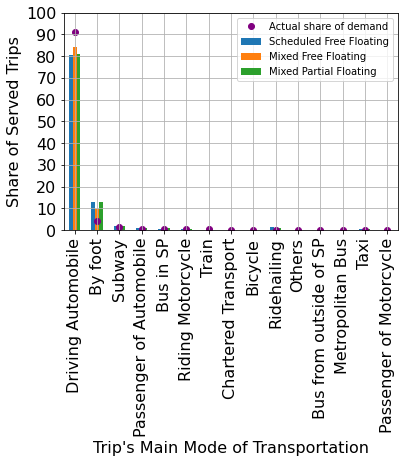

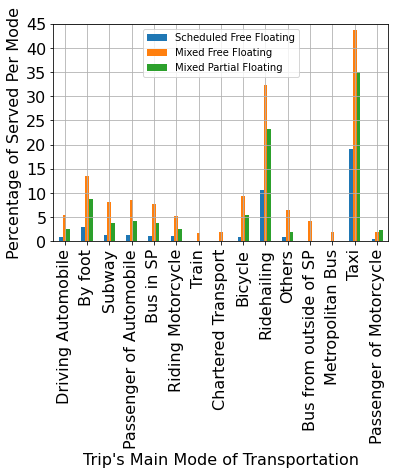

In [36]:
translateModes = {  1: 'Subway',
                    2: 'Train',
                    3: 'Monorail',
                    4: 'Bus in SP',
                    5: 'Bus from outside of SP',
                    6: 'Metropolitan Bus',
                    7: 'Chartered Transport',
                    8: 'Student\'s Transport',
                    9: 'Driving Automobile',
                    10: 'Passenger of Automobile',
                    11: 'Taxi',
                    12: 'Ridehailing',
                    13: 'Riding Motorcycle',
                    14: 'Passenger of Motorcycle',
                    15: 'Bicycle',
                    16: 'By foot',
                    17: 'Others'}

Trip.sharePeopleMainMode = dict()
Trip.percentageServedMainMode = initDictMultiplierPercentages(evaluatedMultipliers)
Trip.shareServedMainMode = initDictMultiplierPercentages(evaluatedMultipliers)
setDictionaries(dictPeople=Trip.amountPeopleMainMode,
                dictServed=Trip.amountServedMainMode,
                dictSharePeople=Trip.sharePeopleMainMode,
                dictPercentageServed=Trip.percentageServedMainMode,
                dictSharedServed=Trip.shareServedMainMode,
                evaluatedMultipliers=evaluatedMultipliers)

sortedKeysPeopleMode = getSortedKeys(dictSharePeople=Trip.sharePeopleMainMode, translateKeys=translateModes)

dataFramePd = getDataFrameSortedIndex(dictSharePeople=Trip.sharePeopleMainMode, sortedKeysPeople=sortedKeysPeopleMode)
ax = dataFramePd.plot(color='purple', marker='o', linestyle='None', zorder=1)

fileName = folderSave / ('Share_Served_Trips_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.shareServedMainMode,
                    dataForIndexing=list(Trip.amountPeopleMainMode.keys()),
                    translateKeys=translateModes,
                    sortedIndex=sortedKeysPeopleMode,
                    xLabel='Trip\'s Main Mode of Transportation',
                    yLabel='Share of Served Trips',
                    yLim=[0, 100],
                    yTicks=range(0, 110, 10),
                    fileName=fileName,
                    ax=ax,
                    zorder=0)

fileName = folderSave / ('Percentage_Served_Per_Mode_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.percentageServedMainMode,
                    dataForIndexing=list(Trip.amountPeopleMainMode.keys()),
                    translateKeys=translateModes,
                    sortedIndex=sortedKeysPeopleMode,
                    xLabel='Trip\'s Main Mode of Transportation',
                    yLabel='Percentage of Served Per Mode',
                    yLim=[0, 45],
                    yTicks=range(0, 50, 5),
                    #legendTitle='Proportion to Uber Base Price',
                    legendLocation='upper center',
                    fileName=fileName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


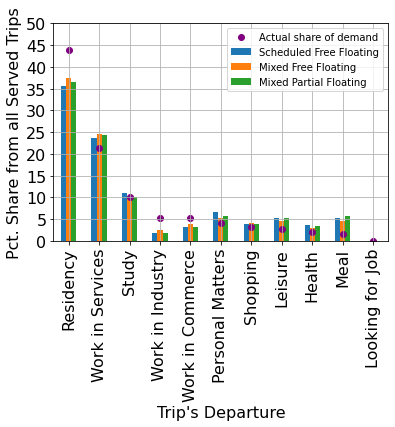

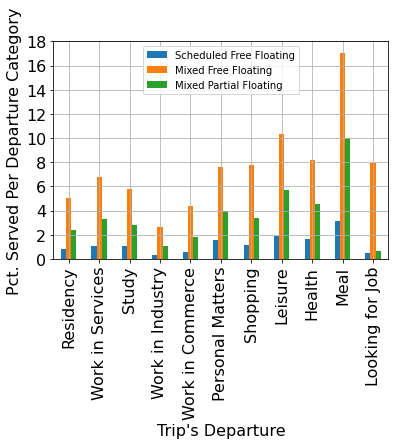

In [37]:
translateReasons = {1: 'Work in Industry',
                    2: 'Work in Commerce',
                    3: 'Work in Services',
                    4: 'Study',
                    5: 'Shopping',
                    6: 'Health',
                    7: 'Leisure',
                    8: 'Residency',
                    9: 'Looking for Job',
                    10: 'Personal Matters',
                    11: 'Meal'}

Trip.sharePeopleDepartureReason = dict()
Trip.percentageServedDepartureReason = initDictMultiplierPercentages(evaluatedMultipliers)
Trip.shareServedDepartureReason = initDictMultiplierPercentages(evaluatedMultipliers)
setDictionaries(dictPeople=Trip.amountPeopleDepartureReason,
                dictServed=Trip.amountServedDepartureReason,
                dictSharePeople=Trip.sharePeopleDepartureReason,
                dictPercentageServed=Trip.percentageServedDepartureReason,
                dictSharedServed=Trip.shareServedDepartureReason,
                evaluatedMultipliers=evaluatedMultipliers)

sortedKeysPeopleReason = getSortedKeys(dictSharePeople=Trip.sharePeopleDepartureReason, translateKeys=translateReasons)

dataFramePd = getDataFrameSortedIndex(dictSharePeople=Trip.sharePeopleDepartureReason, sortedKeysPeople=sortedKeysPeopleReason)
ax = dataFramePd.plot(color='purple', marker='o', linestyle='None', zorder=1)

fileName = folderSave / ('Share_Served_Departure_Category_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.shareServedDepartureReason,
                    dataForIndexing=list(Trip.amountPeopleDepartureReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Departure',
                    yLabel='Pct. Share from all Served Trips',
                    yLim=[0, 50],
                    yTicks=range(0, 55, 5),
                    fileName=fileName,
                    ax=ax,
                    zorder=0)

fileName = folderSave / ('Percentage_Served_Per_Departure_Category_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.percentageServedDepartureReason,
                    dataForIndexing=list(Trip.amountPeopleDepartureReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Departure',
                    yLabel='Pct. Served Per Departure Category',
                    yLim=[0, 18],
                    yTicks=range(0, 20, 2),
                    #legendTitle='Proportion to Uber Base Price',
                    legendLocation='upper center',
                    fileName=fileName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


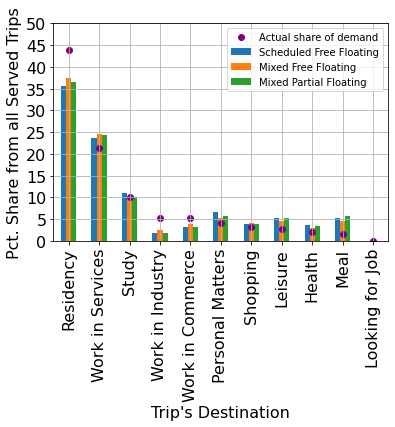

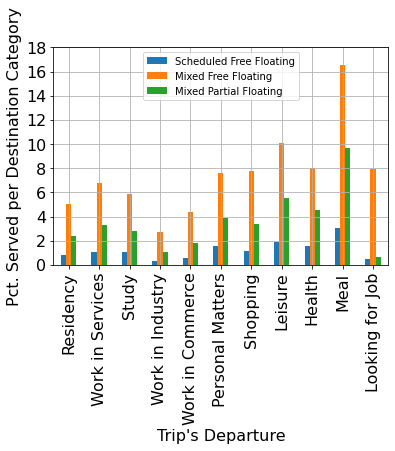

In [38]:
Trip.sharePeopleDestinationReason = dict()
Trip.percentageServedDestinationReason = initDictMultiplierPercentages(evaluatedMultipliers)
Trip.shareServedDestinationReason = initDictMultiplierPercentages(evaluatedMultipliers)
setDictionaries(dictPeople=Trip.amountPeopleDestinationReason,
                dictServed=Trip.amountServedDestinationReason,
                dictSharePeople=Trip.sharePeopleDestinationReason,
                dictPercentageServed=Trip.percentageServedDestinationReason,
                dictSharedServed=Trip.shareServedDestinationReason,
                evaluatedMultipliers=evaluatedMultipliers)

sortedKeysPeopleReason = getSortedKeys(dictSharePeople=Trip.sharePeopleDestinationReason, translateKeys=translateReasons)

dataFramePd = getDataFrameSortedIndex(dictSharePeople=Trip.sharePeopleDestinationReason, sortedKeysPeople=sortedKeysPeopleReason)
ax = dataFramePd.plot(color='purple', marker='o', linestyle='None', zorder=1)

fileName = folderSave / ('Share_Served_Destination_Category_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.shareServedDestinationReason,
                    dataForIndexing=list(Trip.amountPeopleDestinationReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Destination',
                    yLabel='Pct. Share from all Served Trips',
                    yLim=[0, 50],
                    yTicks=range(0, 55, 5),
                    fileName=fileName,
                    ax=ax,
                    zorder=0)

fileName = folderSave / ('Percentage_Served_Per_Destination_Category_' + textMultiplier + '.eps')
ax = prepareBarPlot(dictOfDataToPlot=Trip.percentageServedDestinationReason,
                    dataForIndexing=list(Trip.amountPeopleDestinationReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Departure',
                    yLabel='Pct. Served per Destination Category',
                    yLim=[0, 18],
                    yTicks=range(0, 20, 2),
                    #legendTitle='Proportion to Uber Base Price',
                    legendLocation='upper center',
                    fileName=fileName)
